In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from IPython.display import Image
warnings.filterwarnings('ignore')

In [2]:
# 問題1, 2, 3, 4
class ScratchLogisticRegression():
    """
    ロジスティック回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue
    lam : float
      正則化パラメータ
    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      訓練データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証データに対する損失の記録

    """

    def __init__(self, num_iter, lr, bias, verbose, lam):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.bias = bias
        self.verbose = verbose
        self.lam = lam
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)

    def fit(self, X, y, X_val=None, y_val=None):
        """
        ロジスティック回帰を学習する。検証データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        if self.bias:
            # 全データの最初のカラムに1を追加
            bias = np.ones((X.shape[0], 1))
            X = np.hstack((bias, X))
            bias = np.ones((X_val.shape[0], 1))
            X_val = np.hstack((bias, X_val))
            
        n_features = X.shape[1]
        # thetaの初期値は全て1
        self.theta = np.zeros((n_features, 1))

        for i in range(self.iter):
            pred_y = self._logistic_hypothesis(X)
            self.loss[i] = self._loss_func(pred_y, y)
            pred_y_val = self._logistic_hypothesis(X_val)
            self.val_loss[i] = self._loss_func(pred_y_val, y_val)
            
            self._gradient_descent(X, y)

            if self.verbose:
                #verboseをTrueにした際は学習過程を出力
                print("{}回目の学習の損失: {} (学習), {} (テスト)".format(i,  self.loss[i], self.val_loss[i]))
    
    def _sigmoid(self, z):
        """
        シグモイド関数

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ

        Returns
        -------
          次の形のndarray, shape (n_samples, 1)
          線形の仮定関数による推定結果

        """
        return 1 / (1 + np.exp(-z))
    
    def _logistic_hypothesis(self, X):
        """
        線形の仮定関数を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ

        Returns
        -------
          次の形のndarray, shape (n_samples, 1)
          線形の仮定関数による推定結果

        """
        return self._sigmoid(X @ self.theta)
    
    def _gradient_descent(self, X, y):
        """
        最急降下法

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ

        Returns
        -------
          次の形のndarray, shape (n_samples, 1)
          線形の仮定関数による推定結果

        """
        n_samples = X.shape[0]
        n_features = X.shape[1]
        pred_y = self._logistic_hypothesis(X)
        for j in range(n_features):
            gradient = 0
            for i in range(n_samples):
                gradient += (pred_y[i] - y[i]) * X[i, j]
            if j == 0:
                self.theta[j] = self.theta[j] - ( self.lr * ( gradient / n_samples))
            else:
                self.theta[j] = self.theta[j] - ( self.lr * (( gradient + self.lam * self.theta[j] ) / n_samples))

    def _loss_func(self, pred_y, y):
        """
        損失関数計算

        Parameters
        ----------
        y_pred : 次の形のndarray, shape (n_samples,)
          推定した値
        y : 次の形のndarray, shape (n_samples,)
          正解値

        Returns
        ----------
        loss : numpy.float
          損失値
        """
        n_samples = y.shape[0]
        loss_term = (1 / n_samples) * ((- 1 * y * np.log(pred_y).T) - ((1 - y) * np.log(1 - pred_y).T)).sum()
        norm_term = (self.lam / (2 * n_samples)) * ((self.theta ** 2).sum())
#         print("loss_term: {}".format(loss_term))
#         print("norm_term: {}".format(norm_term))
        return loss_term + norm_term

    def predict(self, X):
        """
        ロジスティック回帰を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        if self.bias:
            bias = np.ones((X.shape[0], 1))
            X = np.hstack((bias, X))
        return np.where(self._logistic_hypothesis(X) <= 0.5, 0, 1)

    def predict_proba(self, X):
        """
        ロジスティック回帰を使い確率を推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        if not self.no_bias:
            bias = np.ones((X.shape[0], 1))
            X = np.hstack((bias, X))
        return self._logistic_hypothesis(X)

In [4]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
iris = load_iris()
X = iris.data[:100,:]
y = iris.target[:100]
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2)

In [26]:
slr = ScratchLogisticRegression(num_iter=10, lr=0.01, bias=False, verbose=True, lam=0.1)
slr.fit(X_train, y_train, X_test, y_test)

0回目の学習の損失: 0.6931471805599454 (学習), 0.6931471805599454 (テスト)
1回目の学習の損失: 0.6917072407231326 (学習), 0.6940096210523612 (テスト)
2回目の学習の損失: 0.6904125441894226 (学習), 0.694787125668446 (テスト)
3回目の学習の損失: 0.6892356454813563 (学習), 0.6954758638755308 (テスト)
4回目の学習の損失: 0.6881543187991659 (学習), 0.6960747899960207 (テスト)
5回目の学習の損失: 0.68715057069473 (学習), 0.696584902499086 (テスト)
6回目の学習の損失: 0.6862098367234424 (学習), 0.6970086650089028 (テスト)
7回目の学習の損失: 0.6853203290073299 (学習), 0.6973495568900038 (テスト)
8回目の学習の損失: 0.6844725070858352 (学習), 0.6976117271049861 (テスト)
9回目の学習の損失: 0.6836586491820553 (学習), 0.6977997299851953 (テスト)


In [45]:
# 問題5
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

slr = ScratchLogisticRegression(num_iter=10, lr=0.01, bias=False, verbose=False, lam=0.1)
slr.fit(X_train, y_train, X_test, y_test)
y_pred = slr.predict(X_test)
ScratchLogisticRegression_iter10_result = pd.DataFrame(
    [accuracy_score(y_test, y_pred), accuracy_score(y_test, y_pred), recall_score(y_test, y_pred)],
    index=['Accuracy', 'Precision', 'Recall'],
    columns=['ScratchLogisticRegression iter=10']
 )
ScratchLogisticRegression_iter10_result

,ScratchLogisticRegression iter=10
Accuracy,0.4
Precision,0.4
Recall,1.0


In [46]:
slr = ScratchLogisticRegression(num_iter=1000, lr=0.01, bias=False, verbose=False, lam=0.1)
slr.fit(X_train, y_train, X_test, y_test)
y_pred = slr.predict(X_test)
ScratchLogisticRegression_iter1000_result = pd.DataFrame(
    [accuracy_score(y_test, y_pred), accuracy_score(y_test, y_pred), recall_score(y_test, y_pred)],
    index=['Accuracy', 'Precision', 'Recall'],
    columns=['ScratchLogisticRegression iter=1000']
 )
ScratchLogisticRegression_iter1000_result

,ScratchLogisticRegression iter=1000
Accuracy,1.0
Precision,1.0
Recall,1.0


In [47]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = slr.predict(X_test)
sklearn_LogisticRegression_result = pd.DataFrame(
    [accuracy_score(y_test, y_pred), accuracy_score(y_test, y_pred), recall_score(y_test, y_pred)],
    index=['Accuracy', 'Precision', 'Recall'],
    columns=['Sklearn LogisticRegression']
 )
sklearn_LogisticRegression_result

,Sklearn LogisticRegression
Accuracy,1.0
Precision,1.0
Recall,1.0


In [48]:
pd.concat([ScratchLogisticRegression_iter10_result, ScratchLogisticRegression_iter1000_result, sklearn_LogisticRegression_result], axis=1)

,ScratchLogisticRegression iter=10,ScratchLogisticRegression iter=1000,Sklearn LogisticRegression
Accuracy,0.4,1.0,1.0
Precision,0.4,1.0,1.0
Recall,1.0,1.0,1.0


iterの回数を上げると完全に正解できた。sklearnも同様

In [6]:
# 問題6 損失値の推移
def display_loss_graph(model):
    iter_list = list(range(1, model.iter + 1))
    plt.scatter(iter_list, model.loss, label="train loss")
    plt.scatter(iter_list, model.val_loss, label="test loss")
    plt.ylabel('loss')
    plt.xlabel('iter')
    plt.legend()
    plt.show()

In [7]:
slr = ScratchLogisticRegression(num_iter=3000, lr=0.01, bias=False, verbose=False, lam=0.1)
slr.fit(X_train, y_train, X_test, y_test)

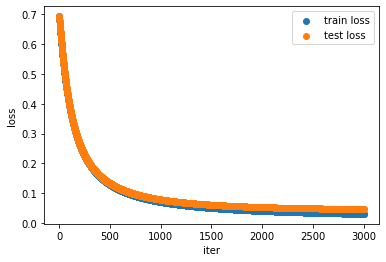

In [8]:
display_loss_graph(slr)

In [9]:
# 問題7
X = iris.data[:100,[0,1]]
y = iris.target[:100]
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2)
slr = ScratchLogisticRegression(num_iter=3000, lr=0.01, bias=False, verbose=False, lam=0.1)
slr.fit(X_train, y_train, X_test, y_test)

In [10]:
from matplotlib.colors import ListedColormap
def display_plot(X, y, model):
    mesh1, mesh2 = np.meshgrid(
        np.arange(np.min(X[:,0]), np.max(X[:,0]), 0.01),
        np.arange(np.min(X[:,1]), np.max(X[:,1]), 0.01)
    )
    mesh = np.c_[np.ravel(mesh1), np.ravel(mesh2)]
    y_pred = slr.predict(mesh).reshape(mesh1.shape)
    plt.xlabel('f0')
    plt.ylabel('f1')
    # contourf: 塗りつぶし
    plt.contourf(mesh1, mesh2, y_pred, cmap=ListedColormap(['pink', 'skyblue']))
    # contour: 等高線
    plt.contour(mesh1, mesh2, y_pred, colors='red')
    plt.scatter(X[y==0][:, 0], X[y==0][:, 1], label='versicolor')
    plt.scatter(X[y==1][:, 0], X[y==1][:, 1], label='virginica')
    plt.legend()
    plt.show()

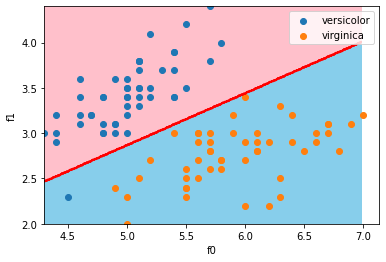

In [11]:
display_plot(X, y, slr)

In [54]:
# 問題8 

# pickleを使ってml model保存
import os
import pickle
os.makedirs(os.path.dirname('./models/scratch_logistic_regression.pkl'), exist_ok=True)
file = './models/scratch_logistic_regression.pkl'
pickle.dump(slr, open(file, 'wb'))

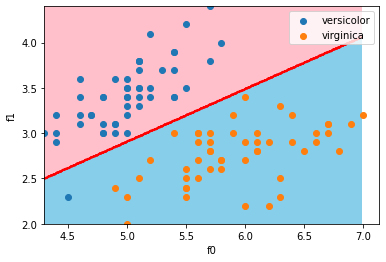

In [55]:
slr_loaded = pickle.load(open(file, 'rb'))
display_plot(X, y, slr_loaded)

In [56]:
# np.savezを使って重み保存後、読み込み
np.save('./models/scratch_logistic_regression_theta', slr.theta)
np.load('./models/scratch_logistic_regression_theta.npy')

array([[ 0.91833185],
       [-1.58099153]])